# Pair Trading of GLD and GDX

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import statsmodels.api as sm

In [5]:
df1=pd.read_excel('GLD.xls')

In [6]:
df2=pd.read_excel('GDX.xls')

In [7]:
df=pd.merge(df1, df2, on='Date', suffixes=('_GLD', '_GDX'))

In [8]:
df.set_index('Date', inplace=True)

In [9]:
df.sort_index(inplace=True)

In [10]:
trainset=np.arange(0, 252)

In [11]:
testset=np.arange(trainset.shape[0], df.shape[0])

## Determine hedge ratio on trainset

In [12]:
model=sm.OLS(df.loc[:, 'Adj Close_GLD'].iloc[trainset], df.loc[:, 'Adj Close_GDX'].iloc[trainset])

In [13]:
results=model.fit()

In [14]:
hedgeRatio=results.params

In [15]:
hedgeRatio

Adj Close_GDX    1.631009
dtype: float64

##  spread = GLD - hedgeRatio*GDX

In [16]:
spread=df.loc[:, 'Adj Close_GLD']-hedgeRatio[0]*df.loc[:, 'Adj Close_GDX']

C:\Users\JOSE\AppData\Local\Temp\ipykernel_14752\328341895.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread=df.loc[:, 'Adj Close_GLD']-hedgeRatio[0]*df.loc[:, 'Adj Close_GDX']


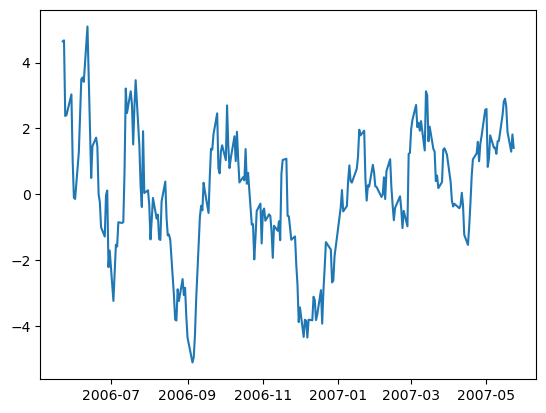

In [17]:
plt.plot(spread.iloc[trainset])

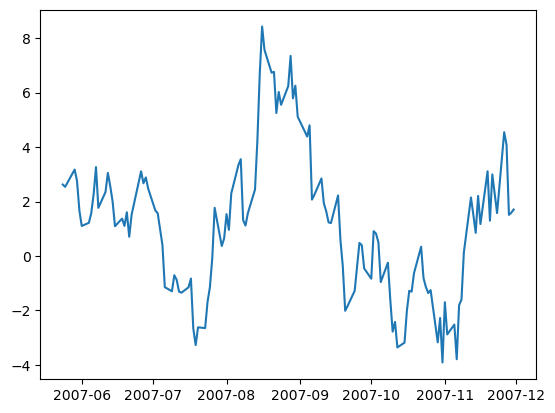

In [18]:
plt.plot(spread.iloc[testset])

In [19]:
spreadMean=np.mean(spread.iloc[trainset])

In [20]:
spreadMean

0.05219623850036005

In [21]:
spreadStd=np.std(spread.iloc[trainset])

In [22]:
spreadStd

1.944860873496509

In [23]:
df['zscore']=(spread-spreadMean)/spreadStd

In [24]:
df['positions_GLD_Long']=0

In [25]:
df['positions_GDX_Long']=0

In [26]:
df['positions_GLD_Short']=0

In [27]:
df['positions_GDX_Short']=0

In [28]:
df.loc[df.zscore>=2, ('positions_GLD_Short', 'positions_GDX_Short')]=[-1, 1] # Short spread

In [29]:
df.loc[df.zscore<=-2, ('positions_GLD_Long', 'positions_GDX_Long')]=[1, -1] # Buy spread

In [30]:
df.loc[df.zscore<=1, ('positions_GLD_Short', 'positions_GDX_Short')]=0 # Exit short spread

In [31]:
df.loc[df.zscore>=-1, ('positions_GLD_Long', 'positions_GDX_Long')]=0 # Exit long spread

In [32]:
df.fillna(method='ffill', inplace=True) # ensure existing positions are carried forward unless there is an exit signal

C:\Users\JOSE\AppData\Local\Temp\ipykernel_14752\3027636567.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True) # ensure existing positions are carried forward unless there is an exit signal


In [33]:
positions_Long=df.loc[:, ('positions_GLD_Long', 'positions_GDX_Long')]

In [34]:
positions_Short=df.loc[:, ('positions_GLD_Short', 'positions_GDX_Short')]

In [35]:
positions=np.array(positions_Long)+np.array(positions_Short)

In [36]:
positions=pd.DataFrame(positions)

In [37]:
dailyret=df.loc[:, ('Adj Close_GLD', 'Adj Close_GDX')].pct_change()

In [38]:
pnl=(np.array(positions.shift())*np.array(dailyret)).sum(axis=1)

In [39]:
sharpeTrainset=np.sqrt(252)*np.mean(pnl[trainset[1:]])/np.std(pnl[trainset[1:]])

In [40]:
sharpeTrainset

1.9182982282569077

In [41]:
sharpeTestset=np.sqrt(252)*np.mean(pnl[testset])/np.std(pnl[testset])

In [42]:
sharpeTestset

1.494313761833427

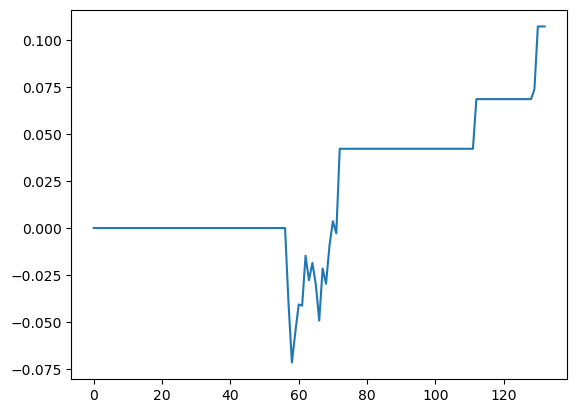

In [43]:
plt.plot(np.cumsum(pnl[testset]))

In [44]:
positions.to_pickle('example3_6_positions')